## Load packages

In [2]:
%pylab inline
import pandas as pd
import seaborn as sns
from numpy import *
from scipy.spatial.distance import euclidean 
from scipy.spatial import distance
from scipy.stats.stats import pearsonr
import datetime
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
import scipy.cluster.hierarchy as sch
from collections import Counter
import itertools
from sklearn.decomposition import PCA as sklearnPCA

def most_common(lst):
    return max(set(lst), key=lst.count)

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#### Load data
**NOTE**: this data is after removing people who failed catch questions

In [3]:
PATH_TO_DATA = "../data/"
df = pd.read_csv(PATH_TO_DATA + "exp1_data.csv')

peopleWords = df["words"]
age = df["age"]
print "Mean age was", round(nanmean(age),1)
gender = df["gender"]
print "There were", sum(gender==2), "women out of", len(gender), "participants"

###  Load GloVe word embeddings
**NOTE**: This file is too big to save on external storage

It can be downloaded from here: http://nlp.stanford.edu/data/glove.6B.zip

We use the 100-dimensional embeddings 

In [8]:
PATH_TO_EMBEDDINGS = "../embeddings/glove.6B.100d.txt"
f = open(PATH_TO_EMBEDDINGS)
lines = f.readlines()
## We form two variables. 'wordVectors' is an array Nx100 of vector representions
## and 'words' is an N-list of strings, where entry i corresponds to vector [i,100] in 
## the wordVectors array. 
wordVectors = array([map(float,x.split(" ")[1:]) for x in lines])
words = [x.split(" ")[0] for x in lines]
f.close()

## Clustering analysis

In [13]:
## Build up a vector representation from words people used 
## We consider only words that appear in the GloVe representation,  
## which excludes slang and non-dictionary words

cleanedPeopleWords = array([w for w in peopleWords if w in words])
peopleWordVectors = zeros([len(cleanedPeopleWords),wordVectors.shape[1]])

for i, word in enumerate(cleanedPeopleWords):
    wordIndex = words.index(word)
    wordVector = wordVectors[wordIndex]
    peopleWordVectors[i,:] = wordVector

### Hierarchical clustering, word analysis

In [15]:
nClusters = 10
hierarchical = sch.ward(peopleWordVectors)
clusters = sch.fcluster(hierarchical, nClusters, criterion='maxclust')
for i in range(1,nClusters + 1):
    a = peopleWordVectors[clusters==i]
    exemplarDistances = distance.cdist(a,a).sum(axis=0)
    ew = cleanedPeopleWords[clusters==i][exemplarDistances.argmin()]
    mfw = Counter(cleanedPeopleWords[clusters==i]).most_common()[0][0]
    print "cluster " + str(i),":",mfw,sum(clusters==i),#ew,#cleanedPeopleWords[clusters==i]
    print ""


cluster 1 : penis 196 
cluster 2 : robot 24 
cluster 3 : banana 68 
cluster 4 : love 134 
cluster 5 : compassion 33 
cluster 6 : empathy 74 
cluster 7 : please 25 
cluster 8 : human 30 
cluster 9 : mercy 140 
cluster 10 : alive 169 


## tSNE figures

In [54]:
from sklearn.manifold import TSNE
sklearn_tsne = TSNE(n_components=2, random_state=0)
sklearn_transf = sklearn_tsne.fit_transform(peopleWordVectors) 

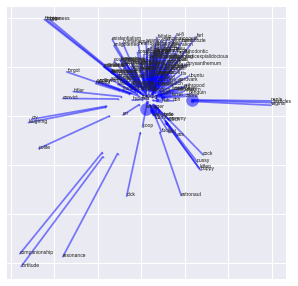

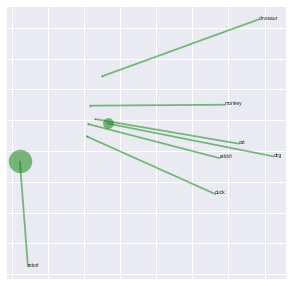

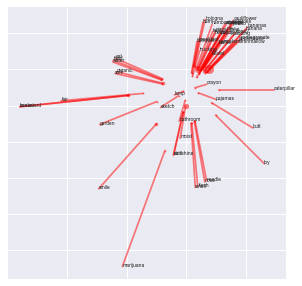

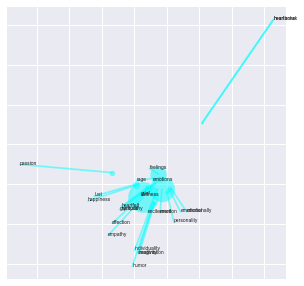

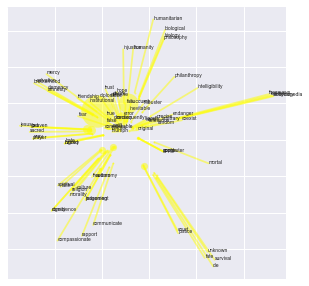

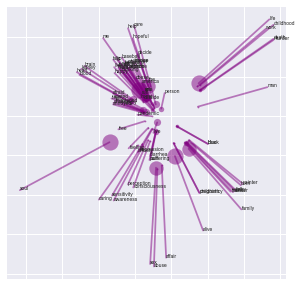

In [51]:
## Generating the SOM figures

## We use tSNE projections of the specific clusters,
## for clusters where the number of words is > 1
## Note that there was additional figure editing 
## Between the figures generated and the paper, 
## that involved moving the labels / connecting lines
## to make the figures readable 

wordsUsed = []
colors = ["blue","green","red","pink","black","cyan","magenta","orange","yellow","purple"]

figsize(5,5)
#fig = figure()
for i in range(1,11):
    if len(unique(cleanedPeopleWords[clusters==i]))>1:
        fig = figure()
        #ax = fig.add_subplot(5,2,i)
        ax = fig.add_subplot(111)
        mfw = Counter(cleanedPeopleWords[clusters==i]).most_common()[0][0]
        relv = sklearn_transf[clusters==i]
        relx = relv[:,0]
        rely = relv[:,1]
        for j,w in enumerate(cleanedPeopleWords[clusters==i]):
            ## USING ONLY WORDS PEOPLE SAID MORE THAN ONCE
            numPeopleSaidWord = commonWordsCount[where(map(lambda x: x[0]==w,commonWordsCount))[0][0]][1]
            if numPeopleSaidWord>0 and not w in wordsUsed:
                markerSize = 1.8*numPeopleSaidWord
                ax.text((2*relx[j]-mean(relx))*1.4,(2*rely[j]-mean(rely))*1.45,w,fontsize=5)
                ax.plot(relx[j],rely[j],\
                     'o', markersize=markerSize, color=colors[i-1], alpha=0.5, label='class1')
                ax.plot((relx[j],(2*relx[j]-mean(relx))*1.4),(rely[j],(2*rely[j]-mean(rely))*1.45),
                        color=colors[i-1], alpha=0.5)
                wordsUsed.append(w)
                ax.set_xticklabels([""])
                ax.set_yticklabels([""])
            

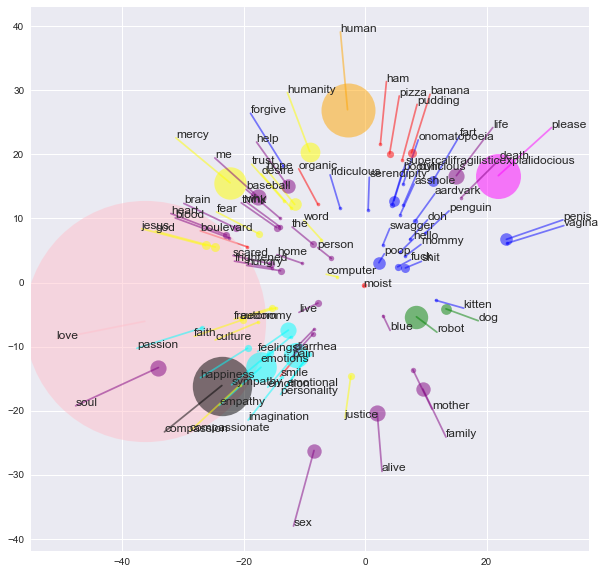

In [55]:
## DISPLAYING ALL CLUSTERS USING tSNE
## Note that there was additional figure editing 
## Between the figure generated and the paper, 
## that involved moving the labels / connecting lines
## to make the figures readable 

commonWordsCount = Counter(cleanedPeopleWords).most_common()

figsize(10,10)
fig = figure()
ax = fig.add_subplot(111)
colors = ["blue","green","red","pink","black","cyan","magenta","orange","yellow","purple"]
wordsUsed = []
for i in range(1,11):
    mfw = Counter(cleanedPeopleWords[clusters==i]).most_common()[0][0]
    relv = sklearn_transf[clusters==i]
    relx = relv[:,0]
    rely = relv[:,1]
    for j,w in enumerate(cleanedPeopleWords[clusters==i]):
        ## USING ONLY WORDS PEOPLE SAID MORE THAN ONCE
        numPeopleSaidWord = commonWordsCount[where(map(lambda x: x[0]==w,commonWordsCount))[0][0]][1]
        if (numPeopleSaidWord>1) and not w in wordsUsed:
            markerSize = 1.8*numPeopleSaidWord
            ax.text(relx[j]*1.4,rely[j]*1.45,w,fontsize=12)
            ax.plot(relx[j],rely[j],\
                 'o', markersize=markerSize, color=colors[i-1], alpha=0.5, label='class1')
            ax.plot((relx[j],relx[j]*1.4),(rely[j],rely[j]*1.45),color=colors[i-1], alpha=0.5)
            wordsUsed.append(w)
            

## Agency and experience ratings of words

In [80]:
peopleRatingAgencyExperience = pd.read_csv(PATH_TO_DATA + "agencyExperienceRatings.csv")

rating1 = array([x for x in peopleRatingAgencyExperience["rater1"]])
rating2 = array([x for x in peopleRatingAgencyExperience["rater2"]])
rating3 = array([x.lower() for x in peopleRatingAgencyExperience["rater3"].values])

ratedAgencyExperience = logical_or(logical_or(logical_or(rating1=="a",rating1=="e"),
                                  logical_or(rating2=="a",rating2=="e")),
                                  logical_or(rating3=="a",rating3=="e"))

print "Fraction of Words that were coded as neither by majority:", round(sum(ratedAgencyExperience)/float(len(ratedAgencyExperience)),2)


Fraction of Words that were coded as neither by majority: 0.69


In [81]:
## Of words that not all raters considered 'neither'
## Accouting for frequency, how many were coded by majority
## as 'agency' or 'experience

majorityRatings = pd.read_csv(PATH_TO_DATA + "not_all_neither_words.csv")
ratedWords = majorityRatings["words"]
majority = majorityRatings["majority"]
a = sum([Counter(cleanedPeopleWords)[x] for x in ratedWords[majority=="a"]])
e = sum([Counter(cleanedPeopleWords)[x] for x in ratedWords[majority=="e"]])
numWords = float(len(cleanedPeopleWords))
print "words related to agency (acct for freq):", round(a/numWords,2)
print "words related to expereince (acct for freq):", round(e/numWords,2)

words related to agency (acct for freq): 0.07
words related to expereince (acct for freq): 0.4
